## Import libraries

In [1]:
# !pip install docplex

import os
import time
import shutil
import pandas as pd
import random
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np

from docplex.mp.model import Model
from docplex.cp.model import CpoModel
from docplex.cp.config import context

# CP Optimizer setup
CP_AVAILABLE = False

# 1) Try to locate cpoptimizer on PATH
exe = shutil.which("cpoptimizer") or shutil.which("cpoptimizer.exe")
if exe:
    context.solver.local.execfile = exe
    CP_AVAILABLE = True

# 2) Fallback: local CPLEX Studio path
if not CP_AVAILABLE:
    CPLEX_STUDIO = r"C:\Program Files\IBM\ILOG\CPLEX_Studio2211"
    cpo_bin   = os.path.join(CPLEX_STUDIO, "cpoptimizer", "bin", "x64_win64")
    cplex_bin = os.path.join(CPLEX_STUDIO, "cplex",      "bin", "x64_win64")

    if os.path.exists(os.path.join(cpo_bin, "cpoptimizer.exe")):
        os.environ["PATH"] = cpo_bin + os.pathsep + cplex_bin + os.pathsep + os.environ.get("PATH", "")
        context.solver.local.execfile = os.path.join(cpo_bin, "cpoptimizer.exe")
        CP_AVAILABLE = True

print("CP available:", CP_AVAILABLE)


CP available: True


## Import data

In [ ]:
CAP_NUM_FOLDER = "data_num"
CAP_LET_FOLDER = "data_let"

# Helper function for number conversion
def to_number(tok):
    try:
        return int(tok)
    except ValueError:
        return float(tok)

# Read small and medium instances files
def read_cap_file(filename):
    with open(filename, "r") as f:
        raw_tokens = f.read().split()
        
    # Token processing (int vs float)
    tokens = []
    for t in raw_tokens:
        try:
            val = float(t)
            if val.is_integer():
                tokens.append(int(val))
            else:
                tokens.append(val)
        except ValueError:
            tokens.append(t)

    idx = 0
    # Dimensions (m: warehouses, n: customers)
    m = int(tokens[idx]); idx += 1
    n = int(tokens[idx]); idx += 1

    # Capacities and Fixed Costs
    capacities = []
    fixed_costs = []
    for _ in range(m):
        capacities.append(tokens[idx]); idx += 1
        fixed_costs.append(tokens[idx]); idx += 1

    # Demands and Transportation Costs Matrix
    demands = []
    costs = [[0]*n for _ in range(m)]

    for j in range(n):
        demands.append(tokens[idx]); idx += 1
        for i in range(m):
            costs[i][j] = tokens[idx]; idx += 1

    return m, n, capacities, fixed_costs, demands, costs

# Read large instances files
def read_large_cap_file(filename, capacity_values):
    with open(filename, "r") as f:
        tokens = f.read().split()

    idx = 0
    # Dimensions
    m = int(tokens[idx]); idx += 1
    n = int(tokens[idx]); idx += 1

    # Fixed Costs
    fixed_costs = []
    for _ in range(m):
        idx += 1
        fixed_costs.append(to_number(tokens[idx])); idx += 1

    # Demands and Transportation Costs
    demands = []
    costs = [[0]*n for _ in range(m)]
    for j in range(n):
        demands.append(to_number(tokens[idx])); idx += 1
        for i in range(m):
            costs[i][j] = to_number(tokens[idx]); idx += 1

    # Create separate instances for each capacity level
    instances = []
    for cap in capacity_values:
        instances.append((m, n, [cap]*m, fixed_costs, demands, costs))

    return instances

# Load all instances from folders
def load_all_instances():
    instances = {}

    # 1. Numeric instances
    for fname in os.listdir(CAP_NUM_FOLDER):
        path = os.path.join(CAP_NUM_FOLDER, fname)
        instances[fname] = read_cap_file(path)

    # 2. "Letter" instances (capa, capb, capc)
    for fname in os.listdir(CAP_LET_FOLDER):
        path = os.path.join(CAP_LET_FOLDER, fname)

        # Define capacities based on file prefix
        if fname.startswith("capa"):
            caps = [8000, 10000, 12000, 14000]
        elif fname.startswith("capb"):
            caps = [5000, 6000, 7000, 8000]
        elif fname.startswith("capc"):
            caps = [5000, 5750, 6500, 7250]
        else:
            continue

        # Read and store instance variations
        insts = read_large_cap_file(path, caps)
        for cap, inst in zip(caps, insts):
            instances[f"{fname}_{cap}"] = inst

    return instances

# Basic instance integrity validation
def validate_instance(instance, name=""):
    m, n, caps, fixed, dem, costs = instance

    # Check dimension consistency
    assert len(caps) == m
    assert len(fixed) == m
    assert len(dem) == n
    assert len(costs) == m
    assert all(len(costs[i]) == n for i in range(m))

    # Check feasibility (Total Capacity >= Total Demand)
    total_demand = sum(dem)
    total_capacity = sum(caps)

    print(f"{name:15s} | total demand = {total_demand:.1f} | total capacity = {total_capacity:.1f}")

    assert total_capacity >= total_demand, f"{name}: capacity < demand"

# Execute loading
all_instances = load_all_instances()

## Instance selection (2×16×50, 2×25×50, 2×100×1000)

In [ ]:
def pick_instances_by_size(instances, m_target, n_target, k=2, prefer_prefixes=None):
    matches = []
    for name, inst in instances.items():
        m, n, *_ = inst
        if m == m_target and n == n_target:
            # Check feasibility: max demand must fit in max capacity
            _, _, caps, _, dems, _ = inst
            if max(dems) <= max(caps):
                matches.append(name)
            else:
                print(f"  Skipping {name}: max_demand={max(dems)} > max_capacity={max(caps)}")

    matches = sorted(matches)

    if prefer_prefixes:
        ordered, used = [], set()
        for p in prefer_prefixes:
            for nm in matches:
                if nm.startswith(p) and nm not in used:
                    ordered.append(nm); used.add(nm)
        for nm in matches:
            if nm not in used:
                ordered.append(nm)
        matches = ordered

    chosen = matches[:k]
    return {nm: instances[nm] for nm in chosen}, chosen

# Instance selection for experiments

# 1) Small instances: 16 x 50
subset_16x50, chosen_16x50 = pick_instances_by_size(
    all_instances,
    m_target=16,
    n_target=50,
    k=2,
    prefer_prefixes=["cap41", "cap42", "cap43", "cap44", "cap4"])

# 2) Medium-small instances: 25 x 50
subset_25x50, chosen_25x50 = pick_instances_by_size(
    all_instances,
    m_target=25,
    n_target=50,
    k=2,
    prefer_prefixes=["cap101", "cap102", "cap103", "cap104", "cap10"])

# 3) Medium instances: 50 x 50
subset_50x50, chosen_50x50 = pick_instances_by_size(
    all_instances,
    m_target=50,
    n_target=50,
    k=2,
    prefer_prefixes=["cap51", "cap52", "cap53", "cap54", "cap5"])

# 4) Large instances: 100 x 1000
subset_100x1000, chosen_100x1000 = pick_instances_by_size(
    all_instances,
    m_target=100,
    n_target=1000,
    k=2,
    prefer_prefixes=["capa", "capb", "capc"])


# Merge all selected instances
selected_instances = {}
for d in [subset_16x50, subset_25x50, subset_50x50, subset_100x1000]:
    selected_instances.update(d)

print("\nSelected instances:")
for nm, inst in selected_instances.items():
    m, n, *_ = inst
    print(f"  - {nm:18s} | m={m:3d}, n={n:4d}")

print("\nChosen lists:")
print("16x50     :", chosen_16x50)
print("25x50     :", chosen_25x50)
print("50x50     :", chosen_50x50)
print("100x1000  :", chosen_100x1000)


  Skipping cap41.txt: max_demand=12912 > max_capacity=5000
  Skipping cap42.txt: max_demand=12912 > max_capacity=5000
  Skipping cap43.txt: max_demand=12912 > max_capacity=5000
  Skipping cap44.txt: max_demand=12912 > max_capacity=5000
  Skipping cap51.txt: max_demand=12912 > max_capacity=10000
  Skipping cap81.txt: max_demand=12912 > max_capacity=5000
  Skipping cap82.txt: max_demand=12912 > max_capacity=5000
  Skipping cap83.txt: max_demand=12912 > max_capacity=5000
  Skipping cap84.txt: max_demand=12912 > max_capacity=5000
  Skipping cap111.txt: max_demand=12912 > max_capacity=5000
  Skipping cap112.txt: max_demand=12912 > max_capacity=5000
  Skipping cap113.txt: max_demand=12912 > max_capacity=5000
  Skipping cap114.txt: max_demand=12912 > max_capacity=5000
Selected instances:
  - cap61.txt          | m= 16, n=  50
  - cap62.txt          | m= 16, n=  50
  - cap101.txt         | m= 25, n=  50
  - cap102.txt         | m= 25, n=  50
  - cap121.txt         | m= 50, n=  50
  - cap122.tx

## Original Capacitated Warehouse Location Problem


## MIP Implementation

In [ ]:
def solve_mip(instance, time_limit=200, log_output=False):
    m, n, capacities, fixed_costs, demands, costs = instance
    
    # Initialize model
    mdl = Model(name="CAP_MIP")
    mdl.context.cplex_parameters.threads = 1

    # Variables
    y = mdl.binary_var_list(m, name="y")        # Is warehouse i open?
    x = mdl.binary_var_matrix(m, n, name="x")   # Is client j assigned to warehouse i?

    # Objective: Minimize fixed costs + transportation costs
    mdl.minimize(
        mdl.sum(fixed_costs[i] * y[i] for i in range(m)) +
        mdl.sum(costs[i][j] * x[i, j] for i in range(m) for j in range(n)))

    # Constraints
    # 1. Demand satisfaction: each client assigned to exactly one warehouse
    for j in range(n):
        mdl.add_constraint(mdl.sum(x[i, j] for i in range(m)) == 1, ctname=f"assign_{j}")

    # 2. Capacity: total demand assigned <= capacity of open warehouse
    for i in range(m):
        mdl.add_constraint(
            mdl.sum(demands[j] * x[i, j] for j in range(n)) <= capacities[i] * y[i],
            ctname=f"cap_{i}") 

    # 3. Linking: cannot assign client to closed warehouse (x_ij <= y_i)
    for i in range(m):
        for j in range(n):
            mdl.add_constraint(x[i, j] <= y[i], ctname=f"link_{i}_{j}")

    # Solve execution
    mdl.parameters.timelimit = time_limit

    start = time.time()
    sol = mdl.solve(log_output=log_output)
    runtime = time.time() - start

    if sol is None:
        return {
            "objective": None, 
            "runtime": runtime, 
            "status": str(mdl.solve_details.status), 
            "opened_warehouses": None}

    # Extract results
    opened = sum(1 for i in range(m) if sol[y[i]] > 0.5)
    
    return {
        "objective": sol.objective_value, 
        "runtime": runtime, 
        "status": str(mdl.solve_details.status), 
        "opened_warehouses": opened}

## CP Model

In [ ]:
def solve_cp(instance, search_type="DepthFirst", time_limit=200):
    m, n, capacities, fixed_costs, demands, costs = instance
    mdl = CpoModel()

    # x[j] = facility serving customer j
    x = mdl.integer_var_list(n, 0, m - 1, name="x")
    open_fac = mdl.binary_var_list(m, name="open")

    max_cap = int(max(capacities))
    load = mdl.integer_var_list(m, 0, max_cap, name="load")

    # Capacity constraints + define load
    for i in range(m):
        mdl.add(load[i] == mdl.sum((x[j] == i) * demands[j] for j in range(n)))
        mdl.add(load[i] <= capacities[i] * open_fac[i])

    # If any customer is assigned to i, then open_fac[i] must be 1
    for i in range(m):
        for j in range(n):
            mdl.add(open_fac[i] >= (x[j] == i))

    for i in range(m):
        mdl.add(open_fac[i] == (load[i] > 0))

    # Transpose cost matrix for element()
    costs_by_customer = [list(col) for col in zip(*costs)]

    mdl.minimize(
        mdl.sum(fixed_costs[i] * open_fac[i] for i in range(m)) +
        mdl.sum(mdl.element(costs_by_customer[j], x[j]) for j in range(n)))

    # decide assignments first
    mdl.set_search_phases([
        mdl.search_phase(x),
        mdl.search_phase(open_fac)])

    mdl.set_parameters(
        TimeLimit=time_limit,
        SearchType=search_type,
        Workers=1,
        LogVerbosity="Quiet")

    start = time.time()
    sol = mdl.solve()
    runtime = time.time() - start

    if not sol or not sol.is_solution():
        return {
            "objective": None,
            "runtime": runtime,
            "status": sol.get_solve_status() if sol else "Fail",
            "opened_warehouses": None}

    opened = sum(1 for i in range(m) if sol.get_value(open_fac[i]) > 0.5)

    return {
        "objective": sol.get_objective_value(),
        "runtime": runtime,
        "status": sol.get_solve_status(),
        "opened_warehouses": opened}

## Solving the Problem - MIP (linear) vs. CP (non-linear)

In [ ]:
def run_experiments(
    instances,
    time_limit_mip=60,
    time_limit_cp=180,
    cp_search=("DepthFirst", "Restart", "MultiPoint")):
    results = []

    for name, instance in instances.items():
        m, n, *_ = instance
        print(f"[ORI] Solving {name} (m={m}, n={n})")

        mip = solve_mip(instance, time_limit=time_limit_mip)
        results.append({
            "instance": name,
            "m": m,
            "n": n,
            "model": "MIP",
            "search": "default",
            "objective": mip.get("objective"),
            "runtime": mip.get("runtime"),
            "status": mip.get("status"),
            "opened_warehouses": mip.get("opened_warehouses")})

        for s in cp_search:
            cp = solve_cp(instance, search_type=s, time_limit=time_limit_cp)
            results.append({
                "instance": name,
                "m": m,
                "n": n,
                "model": "CP",
                "search": s,
                "objective": cp.get("objective"),
                "runtime": cp.get("runtime"),
                "status": cp.get("status"),
                "opened_warehouses": cp.get("opened_warehouses")})

    return pd.DataFrame(results)


In [ ]:
TIME_MIP = 400
TIME_CP = 400
CP_SEARCH = ("DepthFirst", "Restart", "MultiPoint")

df = run_experiments(
    selected_instances,
    time_limit_mip=TIME_MIP,
    time_limit_cp=TIME_CP,
    cp_search=CP_SEARCH)

df

[ORI] Solving cap61.txt (m=16, n=50)
[ORI] Solving cap62.txt (m=16, n=50)
[ORI] Solving cap101.txt (m=25, n=50)
[ORI] Solving cap102.txt (m=25, n=50)
[ORI] Solving cap121.txt (m=50, n=50)
[ORI] Solving cap122.txt (m=50, n=50)
[ORI] Solving capa.txt_10000 (m=100, n=1000)
[ORI] Solving capa.txt_12000 (m=100, n=1000)


,instance,m,n,model,search,objective,runtime,status,opened_warehouses
0,cap61.txt,16,50,MIP,default,9.326158e+05,0.172050,integer optimal solution,11
1,cap61.txt,16,50,CP,DepthFirst,1.355652e+06,400.343646,Feasible,9
2,cap61.txt,16,50,CP,Restart,9.326158e+05,40.715380,Optimal,11
3,cap61.txt,16,50,CP,MultiPoint,9.326158e+05,400.051459,Feasible,11
4,cap62.txt,16,50,MIP,default,9.777994e+05,0.044142,integer optimal solution,9
5,cap62.txt,16,50,CP,DepthFirst,1.430653e+06,400.122254,Feasible,6
6,cap62.txt,16,50,CP,Restart,9.777994e+05,400.148887,Feasible,9
7,cap62.txt,16,50,CP,MultiPoint,9.777994e+05,400.160512,Feasible,9
8,cap101.txt,25,50,MIP,default,7.966484e+05,0.119207,integer optimal solution,15
9,cap101.txt,25,50,CP,DepthFirst,1.133997e+06,400.121283,Feasible,11


## Summaries - Original Model

In [ ]:
# Extract best CP run for each instance (lowest objective, then fastest time)
cp_best = (
    df[df["model"] == "CP"]
      .dropna(subset=["objective"])
      .sort_values(["instance", "objective", "runtime"])
      .groupby("instance", as_index=False)
      .first()
      .rename(columns={
          "search": "best_cp_search",
          "objective": "best_cp_obj",
          "runtime": "best_cp_time",
          "opened_warehouses": "best_cp_opened",
          "status": "best_cp_status"
      })[["instance","best_cp_search","best_cp_obj","best_cp_time","best_cp_opened","best_cp_status"]])

# Extract MIP results for comparison
mip_ref = (
    df[df["model"] == "MIP"]
      .rename(columns={
          "objective": "mip_obj",
          "runtime": "mip_time",
          "opened_warehouses": "mip_opened",
          "status": "mip_status"
      })[["instance","mip_obj","mip_time","mip_opened","mip_status"]]
      .copy())

# Merge for side-by-side comparison
summary_ori = mip_ref.merge(cp_best, on="instance", how="left")

# Check if MIP found an optimal solution
summary_ori["mip_is_optimal"] = summary_ori["mip_status"].str.contains("optimal", case=False, na=False)

# Calculate percentage gap: (CP - MIP) / MIP
summary_ori["cp_gap_vs_mip_pct"] = None
mask = summary_ori["mip_obj"].notna() & summary_ori["best_cp_obj"].notna() & (summary_ori["mip_obj"] != 0)
summary_ori.loc[mask, "cp_gap_vs_mip_pct"] = 100 * (summary_ori.loc[mask, "best_cp_obj"] - summary_ori.loc[mask, "mip_obj"]) / summary_ori.loc[mask, "mip_obj"]

# Sort: Optimal MIPs first, then smallest gap
summary_ori.sort_values(["mip_is_optimal", "cp_gap_vs_mip_pct"], ascending=[False, True])

,instance,mip_obj,mip_time,mip_opened,mip_status,best_cp_search,best_cp_obj,best_cp_time,best_cp_opened,best_cp_status,mip_is_optimal,cp_gap_vs_mip_pct
4,cap121.txt,7.934396e+05,0.211422,15,integer optimal solution,Restart,7.934396e+05,400.237779,15,Feasible,True,0.0
1,cap62.txt,9.777994e+05,0.044142,9,integer optimal solution,MultiPoint,9.777994e+05,400.160512,9,Feasible,True,0.0
2,cap101.txt,7.966484e+05,0.119207,15,integer optimal solution,Restart,7.966484e+05,400.207745,15,Feasible,True,0.0
3,cap102.txt,8.547042e+05,0.081453,11,integer optimal solution,Restart,8.547042e+05,400.129117,11,Feasible,True,0.0
0,cap61.txt,9.326158e+05,0.172050,11,integer optimal solution,Restart,9.326158e+05,40.715380,11,Optimal,True,0.0
5,cap122.txt,8.549005e+05,0.293486,12,integer optimal solution,Restart,8.582359e+05,400.258245,12,Feasible,True,0.390155
7,capa.txt_12000,1.776520e+07,400.207924,5,time limit exceeded,Restart,2.799581e+07,405.479339,8,Feasible,False,57.587904
6,capa.txt_10000,1.844027e+07,400.282693,6,time limit exceeded,Restart,3.489934e+07,403.334781,10,Feasible,False,89.256122


# Extended Capacitated Warehouse Location Problem

## 1. Auxiliary functions for the Extended Problem

In [9]:
def build_soft_incompatibilities(fixed_costs, rho=0.10, density=0.10, seed=42):
    """
    Builds a set S of warehouse pairs subject to a co-opening penalty (soft discouragement).
    - density: fraction of all (i,k) pairs included in S
    - penalty P_ik = rho * (f_i + f_k)
    """
    m = len(fixed_costs)
    all_pairs = list(combinations(range(m), 2))
    K = max(1, int(round(density * len(all_pairs))))

    rng = random.Random(seed)
    S_pairs = rng.sample(all_pairs, K)

    penalty = {(i, k): rho * (fixed_costs[i] + fixed_costs[k]) for (i, k) in S_pairs}
    return S_pairs, penalty


def build_regions(m):
    """
    Assign warehouses to regions (0-based region indices).
    Rule:
      - m = 16 or 25 -> 6 regions
      - m = 50      -> 9 regions
      - m = 100     -> 12 regions

    Returns:
      region_of : list length m, region_of[i] in {0,...,r-1}
      r         : number of regions
      I_r       : list of lists, I_r[rr] = warehouses in region rr
    """
    if m in (16, 25):
        r = 6
    elif m == 50:
        r = 9
    elif m == 100:
        r = 12
    else:
        r = max(2, min(m, int(round(m / 8))))

    # Balanced deterministic assignment
    region_of = [i % r for i in range(m)]

    I_r = [[] for _ in range(r)]
    for i, rr in enumerate(region_of):
        I_r[rr].append(i)

    # no empty regions
    empty = [rr for rr in range(r) if len(I_r[rr]) == 0]
    if empty:
        raise ValueError(f"Empty regions found: {empty}. Fix build_regions().")

    return region_of, r, I_r


def build_C_pairs(region_of, T):
    """
    Build the set C of penalized cross-regional warehouse pairs:
      C = {(i,k): i<k and (reg(i), reg(k)) in T}  (with ordered region pair)

    Inputs:
      region_of : list length m with region_of[i] = region index
      T         : set of ordered region pairs (r,s) with r < s (0-based)

    Returns:
      C_pairs: list of warehouse index pairs (i,k) with i<k
    """
    m = len(region_of)
    C_pairs = []
    for i in range(m):
        ri = region_of[i]
        for k in range(i + 1, m):
            rk = region_of[k]
            rmin, rmax = (ri, rk) if ri < rk else (rk, ri)
            if (rmin, rmax) in T:
                C_pairs.append((i, k))
    return C_pairs


def get_region_penalties(m):
    """
    Returns:
      T    : set of ordered region pairs (rr, ss) with rr < ss, 0-based
      P_rs : dict mapping (rr, ss) -> penalty weight (float/int)

    T and P_rs are allowed to depend on m (hence on r).
    This avoids invalid pairs when r is smaller (e.g., r=6).
    """
    _, r, _ = build_regions(m)

    # Define T and P_rs per r
    if r == 6:
        # Example arbitrary pairs among regions {0..5}
        T = {
            (0, 4),  # (1,5) in 1-based
            (1, 5),  # (2,6)
            (2, 4),  # (3,5)
        }
        P_rs = {
            (0, 4): 900,
            (1, 5): 1200,
            (2, 4): 700,
        }

    elif r == 9:
        # Example arbitrary pairs among regions {0..8}
        T = {
            (0, 7),  # (1,8)
            (1, 5),  # (2,6)
            (3, 4),  # (4,5)
            (2, 8),  # (3,9)
        }
        P_rs = {
            (0, 7): 1500,
            (1, 5): 900,
            (3, 4): 600,
            (2, 8): 1300,
        }

    elif r == 12:
        # Example arbitrary pairs among regions {0..11}
        T = {
            (0, 7),   # (1,8)
            (1, 5),   # (2,6)
            (3, 4),   # (4,5)
            (0, 10),  # (1,11)
            (2, 9),   # (3,10)
        }
        P_rs = {
            (0, 7): 1500,
            (1, 5): 900,
            (3, 4): 600,
            (0, 10): 1800,
            (2, 9): 1400,
        }

    else:
        T = set()
        P_rs = {}

    for (rr, ss) in T:
        if not (0 <= rr < ss < r):
            raise ValueError(f"Invalid region pair {(rr, ss)} for r={r} (m={m}). Fix get_region_penalties().")
        if (rr, ss) not in P_rs:
            raise ValueError(f"Missing penalty weight for region pair {(rr, ss)} in P_rs (r={r}, m={m}).")

    return T, P_rs


## 2. Extended MIP

In [ ]:
def solve_mip_extended(instance, rho=0.10, density=0.10, seed=42, time_limit=200, log_output=False):
    m, n, capacities, fixed_costs, demands, costs = instance

    # S: soft warehouse-pair penalties
    S_pairs, penalty_S = build_soft_incompatibilities(
        fixed_costs, rho=rho, density=density, seed=seed)

    # Regions and cross-region penalties
    region_of, r, I_r = build_regions(m)
    T, P_rs = get_region_penalties(m)
    C_pairs = build_C_pairs(region_of, T)

    mdl = Model(name="CAP_MIP_EXT")
    mdl.context.cplex_parameters.threads = 1

    # Variables
    y = mdl.binary_var_list(m, name="y")
    x = mdl.binary_var_matrix(m, n, name="x")

    z = {(i, k): mdl.binary_var(name=f"z_{i}_{k}") for (i, k) in S_pairs}
    delta = {(i, k): mdl.binary_var(name=f"delta_{i}_{k}") for (i, k) in C_pairs}

    # Objective
    mdl.minimize(
        mdl.sum(fixed_costs[i] * y[i] for i in range(m)) +
        mdl.sum(costs[i][j] * x[i, j] for i in range(m) for j in range(n)) +
        mdl.sum(penalty_S[(i, k)] * z[(i, k)] for (i, k) in S_pairs) +
        mdl.sum(
            P_rs[tuple(sorted((region_of[i], region_of[k])))] * delta[(i, k)]
            for (i, k) in C_pairs))

    # Constraints
    # Demand satisfaction
    for j in range(n):
        mdl.add_constraint(mdl.sum(x[i, j] for i in range(m)) == 1, ctname=f"assign_{j}")

    # Capacity
    for i in range(m):
        mdl.add_constraint(
            mdl.sum(demands[j] * x[i, j] for j in range(n)) <= capacities[i] * y[i],
            ctname=f"cap_{i}")

    # Linking
    for i in range(m):
        for j in range(n):
            mdl.add_constraint(x[i, j] <= y[i], ctname=f"link_{i}_{j}")

    # Soft incompatibilities: z_ik = AND(y_i, y_k)
    for (i, k) in S_pairs:
        mdl.add_constraint(z[(i, k)] >= y[i] + y[k] - 1, ctname=f"zlb_{i}_{k}")
        mdl.add_constraint(z[(i, k)] <= y[i], ctname=f"zub1_{i}_{k}")
        mdl.add_constraint(z[(i, k)] <= y[k], ctname=f"zub2_{i}_{k}")

    # Regional coverage (hard)
    for rr in range(r):
        mdl.add_constraint(mdl.sum(y[i] for i in I_r[rr]) >= 1, ctname=f"cover_{rr}")

    # Cross-region intensity: delta_ik = AND(y_i, y_k)
    for (i, k) in C_pairs:
        mdl.add_constraint(delta[(i, k)] >= y[i] + y[k] - 1, ctname=f"dlb_{i}_{k}")
        mdl.add_constraint(delta[(i, k)] <= y[i], ctname=f"dub1_{i}_{k}")
        mdl.add_constraint(delta[(i, k)] <= y[k], ctname=f"dub2_{i}_{k}")

    mdl.parameters.timelimit = time_limit

    start = time.time()
    sol = mdl.solve(log_output=log_output)
    runtime = time.time() - start

    if sol is None:
        return {
            "objective": None,
            "runtime": runtime,
            "status": str(mdl.solve_details.status),
            "opened_warehouses": None,
            "violated_pairs": None,
            "violated_region_pairs": None}

    opened = sum(1 for i in range(m) if sol[y[i]] > 0.5)
    violated_S = sum(1 for (i, k) in S_pairs if sol[z[(i, k)]] > 0.5)
    violated_C = sum(1 for (i, k) in C_pairs if sol[delta[(i, k)]] > 0.5)

    return {
        "objective": sol.objective_value,
        "runtime": runtime,
        "status": str(mdl.solve_details.status),
        "opened_warehouses": opened,
        "violated_pairs": violated_S,
        "violated_region_pairs": violated_C}


## 2. Extended CP

In [ ]:
def solve_cp_extended(
    instance,
    rho=0.10,
    density=0.10,
    seed=42,
    search_type="DepthFirst",
    time_limit=200
):
    m, n, capacities, fixed_costs, demands, costs = instance

    # S: soft warehouse-pair penalties
    S_pairs, penalty_S = build_soft_incompatibilities(
        fixed_costs, rho=rho, density=density, seed=seed)

    # Regions and cross-region penalties
    region_of, r, I_r = build_regions(m)
    T, P_rs = get_region_penalties(m)
    C_pairs = build_C_pairs(region_of, T)

    mdl = CpoModel()

    # Decision variables
    x = mdl.integer_var_list(n, 0, m - 1, name="x")     # facility serving customer j
    open_fac = mdl.binary_var_list(m, name="open")      # 1 if facility i is open

    max_cap = int(max(capacities))
    load = mdl.integer_var_list(m, 0, max_cap, name="load")

    # Capacity + load definition
    for i in range(m):
        mdl.add(load[i] == mdl.sum((x[j] == i) * demands[j] for j in range(n)))
        mdl.add(load[i] <= capacities[i] * open_fac[i])

    # If customer j assigned to i => open_fac[i] must be 1
    for i in range(m):
        for j in range(n):
            mdl.add(open_fac[i] >= (x[j] == i))

    # open_fac[i] is 1 iff some load is assigned to i
    for i in range(m):
        mdl.add(open_fac[i] == (load[i] > 0))

    # Regional coverage (hard): at least one open warehouse per region
    for rr in range(r):
        mdl.add(mdl.sum(open_fac[i] for i in I_r[rr]) >= 1)

    # Costs for element(): costs_by_customer[j][i] = cost to serve j from i
    costs_by_customer = [list(col) for col in zip(*costs)]

    # Soft S-pair penalty: min(open_i, open_k) equals 1 if both open (binary vars)
    penalty_S_term = mdl.sum(
        penalty_S[(i, k)] * mdl.min(open_fac[i], open_fac[k])
        for (i, k) in S_pairs)

    # Cross-region intensity penalty on C-pairs
    penalty_region_term = mdl.sum(
        P_rs[tuple(sorted((region_of[i], region_of[k])))] * mdl.min(open_fac[i], open_fac[k])
        for (i, k) in C_pairs)

    # Objective
    mdl.minimize(
        mdl.sum(fixed_costs[i] * open_fac[i] for i in range(m)) +
        mdl.sum(mdl.element(costs_by_customer[j], x[j]) for j in range(n)) +
        penalty_S_term +
        penalty_region_term)

    # Decide assignments first
    mdl.set_search_phases([
        mdl.search_phase(x),
        mdl.search_phase(open_fac)])

    # Parameters
    mdl.set_parameters(
        TimeLimit=time_limit,
        SearchType=search_type,
        Workers=1,
        LogVerbosity="Quiet")

    start = time.time()
    sol = mdl.solve()
    runtime = time.time() - start

    if not sol or not sol.is_solution():
        return {
            "objective": None,
            "runtime": runtime,
            "status": sol.get_solve_status() if sol else "Fail",
            "opened_warehouses": None,
            "violated_pairs": None,
            "violated_region_pairs": None}

    opened = sum(1 for i in range(m) if sol.get_value(open_fac[i]) > 0.5)

    violated_S = sum(
        1 for (i, k) in S_pairs
        if sol.get_value(open_fac[i]) > 0.5 and sol.get_value(open_fac[k]) > 0.5 )

    violated_C = sum(
        1 for (i, k) in C_pairs
        if sol.get_value(open_fac[i]) > 0.5 and sol.get_value(open_fac[k]) > 0.5)

    return {
        "objective": sol.get_objective_value(),
        "runtime": runtime,
        "status": sol.get_solve_status(),
        "opened_warehouses": opened,
        "violated_pairs": violated_S,
        "violated_region_pairs": violated_C}


## 4. Run experiments for extended model

In [ ]:
def run_experiments_extended(
    instances,
    rho=0.10,
    density=0.10,
    seed=42,
    time_limit_mip=60,
    time_limit_cp=180,
    cp_search=("DepthFirst", "Restart", "MultiPoint")
):
    results = []

    for name, instance in instances.items():
        m, n, *_ = instance
        print(f"[EXT] Solving {name} (m={m}, n={n})")

        # MIP extended
        mip = solve_mip_extended(
            instance,
            rho=rho,
            density=density,
            seed=seed,
            time_limit=time_limit_mip)

        results.append({
            "instance": name,
            "m": m,
            "n": n,
            "model": "MIP_EXT",
            "search": "default",
            "objective": mip.get("objective"),
            "runtime": mip.get("runtime"),
            "status": mip.get("status"),
            "opened_warehouses": mip.get("opened_warehouses"),
            "violated_pairs": mip.get("violated_pairs"),
            "violated_region_pairs": mip.get("violated_region_pairs") })

        # CP extended (multiple search types)
        for s in cp_search:
            cp = solve_cp_extended(
                instance,
                rho=rho,
                density=density,
                seed=seed,
                search_type=s,
                time_limit=time_limit_cp)

            results.append({
                "instance": name,
                "m": m,
                "n": n,
                "model": "CP_EXT",
                "search": s,
                "objective": cp.get("objective"),
                "runtime": cp.get("runtime"),
                "status": cp.get("status"),
                "opened_warehouses": cp.get("opened_warehouses"),
                "violated_pairs": cp.get("violated_pairs"),
                "violated_region_pairs": cp.get("violated_region_pairs")})

    return pd.DataFrame(results)

In [ ]:
TIME_MIP = 400
TIME_CP = 400
CP_SEARCH = ("DepthFirst", "Restart", "MultiPoint")
RHO = 0.10
DENSITY = 0.10
SEED = 42

df_ext = run_experiments_extended(
    selected_instances,
    rho=RHO,
    density=DENSITY,
    seed=SEED,
    time_limit_mip=TIME_MIP,
    time_limit_cp=TIME_CP,
    cp_search=CP_SEARCH)

df_ext

[EXT] Solving cap61.txt (m=16, n=50)
[EXT] Solving cap62.txt (m=16, n=50)
[EXT] Solving cap101.txt (m=25, n=50)
[EXT] Solving cap102.txt (m=25, n=50)
[EXT] Solving cap121.txt (m=50, n=50)
[EXT] Solving cap122.txt (m=50, n=50)
[EXT] Solving capa.txt_10000 (m=100, n=1000)
[EXT] Solving capa.txt_12000 (m=100, n=1000)


,instance,m,n,model,search,objective,runtime,status,opened_warehouses,violated_pairs,violated_region_pairs
0,cap61.txt,16,50,MIP_EXT,default,9.433763e+05,0.177866,integer optimal solution,10.0,3.0,7.0
1,cap61.txt,16,50,CP_EXT,DepthFirst,1.395591e+06,400.149480,Feasible,8.0,3.0,5.0
2,cap61.txt,16,50,CP_EXT,Restart,9.433763e+05,15.602940,Optimal,10.0,3.0,7.0
3,cap61.txt,16,50,CP_EXT,MultiPoint,9.434132e+05,400.110888,Feasible,10.0,3.0,7.0
4,cap62.txt,16,50,MIP_EXT,default,9.885994e+05,0.121334,integer optimal solution,9.0,3.0,6.0
5,cap62.txt,16,50,CP_EXT,DepthFirst,1.441717e+06,400.113995,Feasible,6.0,1.0,3.0
6,cap62.txt,16,50,CP_EXT,Restart,9.885994e+05,78.033030,Optimal,9.0,3.0,6.0
7,cap62.txt,16,50,CP_EXT,MultiPoint,9.885994e+05,400.062314,Feasible,9.0,3.0,6.0
8,cap101.txt,25,50,MIP_EXT,default,8.228196e+05,0.131904,integer optimal solution,13.0,6.0,15.0
9,cap101.txt,25,50,CP_EXT,DepthFirst,1.188806e+06,400.049247,Feasible,11.0,5.0,12.0


## Summaries - Extended Model

In [ ]:
# Extract best CP run for Extended model (including violation metrics)
cp_best_ext = (
    df_ext[df_ext["model"] == "CP_EXT"]
      .dropna(subset=["objective"])
      .sort_values(["instance", "objective", "runtime"])
      .groupby("instance", as_index=False)
      .first()
      .rename(columns={
          "search": "best_cp_search",
          "objective": "best_cp_obj",
          "runtime": "best_cp_time",
          "opened_warehouses": "best_cp_opened",
          "status": "best_cp_status",
          "violated_pairs": "best_cp_violated_S",
          "violated_region_pairs": "best_cp_violated_C"
      })[["instance", "best_cp_search", "best_cp_obj", "best_cp_time", 
          "best_cp_opened", "best_cp_status", "best_cp_violated_S", "best_cp_violated_C"]])

# Extract MIP results for Extended model as baseline
mip_ref_ext = (
    df_ext[df_ext["model"] == "MIP_EXT"]
      .rename(columns={
          "objective": "mip_obj",
          "runtime": "mip_time",
          "opened_warehouses": "mip_opened",
          "status": "mip_status",
          "violated_pairs": "mip_violated_S",
          "violated_region_pairs": "mip_violated_C"
      })[["instance", "mip_obj", "mip_time", "mip_opened", "mip_status", "mip_violated_S", "mip_violated_C"]]
      .copy())

# Merge for side-by-side comparison
summary_ext = mip_ref_ext.merge(cp_best_ext, on="instance", how="left")

# Check if MIP found an optimal solution
summary_ext["mip_is_optimal"] = summary_ext["mip_status"].str.contains("optimal", case=False, na=False)

# Calculate percentage gap: (CP - MIP) / MIP
summary_ext["cp_gap_vs_mip_pct"] = None
mask = summary_ext["mip_obj"].notna() & summary_ext["best_cp_obj"].notna() & (summary_ext["mip_obj"] != 0)
summary_ext.loc[mask, "cp_gap_vs_mip_pct"] = 100 * (summary_ext.loc[mask, "best_cp_obj"] - summary_ext.loc[mask, "mip_obj"]) / summary_ext.loc[mask, "mip_obj"]

# Sort: Optimal MIPs first, then smallest gap
summary_ext = summary_ext.sort_values(["mip_is_optimal", "cp_gap_vs_mip_pct"], ascending=[False, True])
summary_ext

,instance,mip_obj,mip_time,mip_opened,mip_status,mip_violated_S,mip_violated_C,best_cp_search,best_cp_obj,best_cp_time,best_cp_opened,best_cp_status,best_cp_violated_S,best_cp_violated_C,mip_is_optimal,cp_gap_vs_mip_pct
3,cap102.txt,8.722032e+05,0.082218,10.0,integer optimal solution,1.0,11.0,Restart,8.722032e+05,400.067163,10.0,Feasible,1.0,11.0,True,0.0
2,cap101.txt,8.228196e+05,0.131904,13.0,integer optimal solution,6.0,15.0,Restart,8.228196e+05,400.064985,13.0,Feasible,6.0,15.0,True,0.0
5,cap122.txt,8.774104e+05,0.793389,11.0,integer optimal solution,2.0,5.0,Restart,8.774104e+05,400.087023,11.0,Feasible,2.0,5.0,True,0.0
4,cap121.txt,8.185426e+05,0.180275,14.0,integer optimal solution,4.0,7.0,Restart,8.185426e+05,400.185845,14.0,Feasible,4.0,7.0,True,0.0
0,cap61.txt,9.433763e+05,0.177866,10.0,integer optimal solution,3.0,7.0,Restart,9.433763e+05,15.602940,10.0,Optimal,3.0,7.0,True,0.0
1,cap62.txt,9.885994e+05,0.121334,9.0,integer optimal solution,3.0,6.0,MultiPoint,9.885994e+05,400.062314,9.0,Feasible,3.0,6.0,True,0.0
7,capa.txt_12000,2.546103e+07,33.639523,12.0,integer optimal solution,1.0,5.0,MultiPoint,6.684570e+07,407.084490,21.0,Feasible,26.0,15.0,True,162.541238
6,capa.txt_10000,2.546103e+07,36.104118,12.0,integer optimal solution,1.0,5.0,MultiPoint,6.813552e+07,403.104278,23.0,Feasible,30.0,16.0,True,167.60708


## Export Tables


In [15]:
df.to_csv("results_original_raw.csv", index=False)
df_ext.to_csv("results_extended_raw.csv", index=False)
summary_ori.to_csv("compare_bestcp_vs_mip_original.csv", index=False)
summary_ext.to_csv("compare_bestcp_vs_mip_extended.csv", index=False)

## Plots

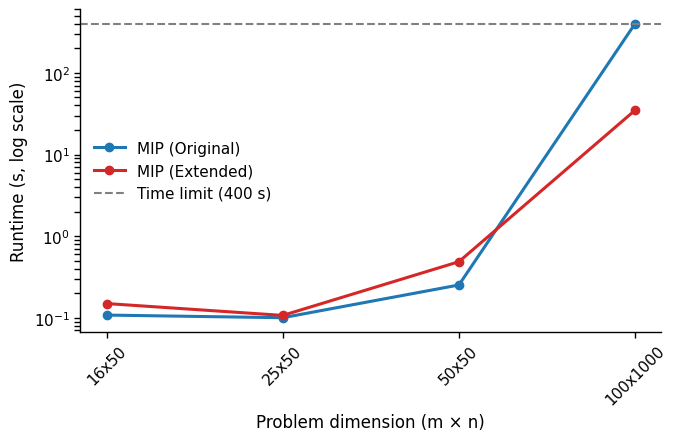

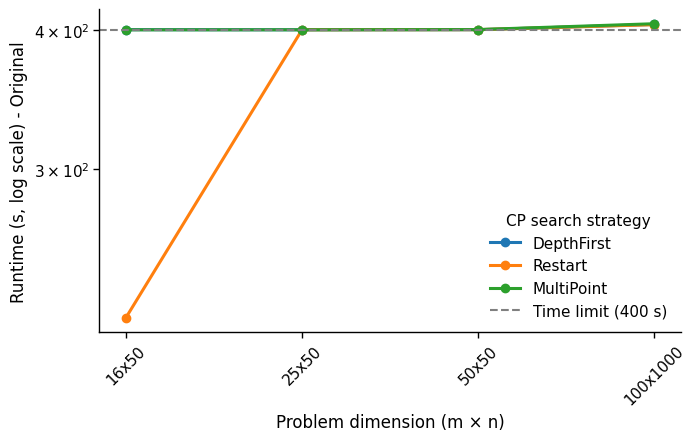

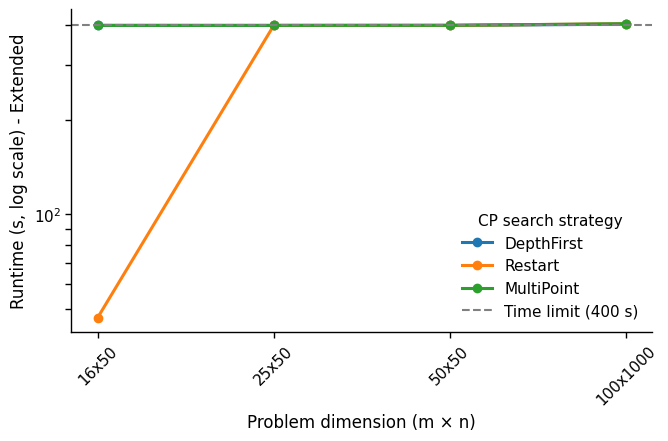

In [ ]:
# Configuration
TIME_LIMIT = 400

# Helper to add dimension columns for plotting
def add_dim(df_in):
    d = df_in.copy()
    d["m"] = pd.to_numeric(d["m"])
    d["n"] = pd.to_numeric(d["n"])
    d["dim"] = d["m"].astype(int).astype(str) + "x" + d["n"].astype(int).astype(str)
    d["size"] = d["m"] * d["n"]
    return d

df_ori_plot = add_dim(df)
df_ext_plot = add_dim(df_ext)

# Define dimension order based on size
dim_order = (
    df_ori_plot[["dim", "size"]]
    .drop_duplicates()
    .sort_values("size")["dim"]
    .tolist())

x = np.arange(len(dim_order))

# Plot styling helper
def style(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    ax.tick_params(axis="both", which="both", direction="out", length=4, width=1)
    ax.tick_params(axis="x", rotation=45)
    ax.grid(False)

def save_fig(fig, name):
    fig.savefig(f"{name}.png", dpi=300, bbox_inches="tight")

plt.rcParams.update({
    "font.size": 11,
    "axes.labelsize": 12,
    "legend.fontsize": 11,
})

# GRAPH 1: MIP Runtime vs Dimension (Original vs Extended)
mip_ori = df_ori_plot[df_ori_plot["model"] == "MIP"]
mip_ext = df_ext_plot[df_ext_plot["model"] == "MIP_EXT"]

# Group by dimension and take median runtime
mip_ori_g = mip_ori.groupby("dim")["runtime"].median()
mip_ext_g = mip_ext.groupby("dim")["runtime"].median()

y_ori = [mip_ori_g[d] if d in mip_ori_g.index else np.nan for d in dim_order]
y_ext = [mip_ext_g[d] if d in mip_ext_g.index else np.nan for d in dim_order]

fig, ax = plt.subplots(figsize=(7.5, 4.2))

ax.plot(x, y_ori, color="#1f77b4", linewidth=2.2, marker="o", label="MIP (Original)")
ax.plot(x, y_ext, color="#d62728", linewidth=2.2, marker="o", label="MIP (Extended)")

ax.axhline(TIME_LIMIT, color="gray", linestyle="--", linewidth=1.5,
           label=f"Time limit ({TIME_LIMIT} s)")

ax.set_yscale("log")
ax.set_xticks(x)
ax.set_xticklabels(dim_order)
ax.set_xlabel("Problem dimension (m × n)")
ax.set_ylabel("Runtime (s, log scale)")

style(ax)
ax.legend(frameon=False)

save_fig(fig, "fig_runtime_mip_vs_dimension")
plt.show()

# Helper for CP plots
def cp_runtime_plot(df_in, model_name, filename, title_suffix=""):
    df_cp = df_in[(df_in["model"] == model_name) & df_in["runtime"].notna()]

    fig, ax = plt.subplots(figsize=(7.5, 4.2))

    colors = {
        "DepthFirst": "#1f77b4",
        "Restart": "#ff7f0e",
        "MultiPoint": "#2ca02c"}

    # Plot line for each search strategy
    for s in ["DepthFirst", "Restart", "MultiPoint"]:
        tmp = df_cp[df_cp["search"] == s]
        if tmp.empty:
            continue
        g = tmp.groupby("dim")["runtime"].median()
        y = [g[d] if d in g.index else np.nan for d in dim_order]
        ax.plot(x, y, marker="o", linewidth=2.2, color=colors.get(s, "black"), label=s)

    ax.axhline(TIME_LIMIT, color="gray", linestyle="--", linewidth=1.5,
               label=f"Time limit ({TIME_LIMIT} s)")

    ax.set_yscale("log")
    ax.set_xticks(x)
    ax.set_xticklabels(dim_order)
    ax.set_xlabel("Problem dimension (m × n)")
    ax.set_ylabel(f"Runtime (s, log scale) - {title_suffix}")

    style(ax)
    ax.legend(title="CP search strategy", frameon=False)

    save_fig(fig, filename)
    plt.show()

# GRAPH 2: CP Original
cp_runtime_plot(
    df_ori_plot,
    model_name="CP",
    filename="fig_runtime_cp_original",
    title_suffix="Original")

# GRAPH 3: CP Extended
cp_runtime_plot(
    df_ext_plot,
    model_name="CP_EXT",
    filename="fig_runtime_cp_extended",
    title_suffix="Extended")